# Neural Network **Regression** with TensorFlow: *Medical Cost Personal Datasets*

There are many definitions for a regression problem. For example, we might want to:
- Predict the selling price of houses given information about them (such as number of rooms, size, number of bathrooms).
- Predict the coordinates of a bounding box of an item in an image.
- Predict the cost of medical insurance for an individual given their demographics (age, sex, gender, race).


Here in this notebook we're going to try predict the cost of medical insurance for individuals based on a number of different parameters such as, `age`, `sex`, `bmi`, `children`, `smoking_status` and `residential_region`.

To do, we'll leverage the pubically available [Medical Cost dataset](https://www.kaggle.com/mirichoi0218/insurance) available from Kaggle and [hosted on GitHub](https://github.com/stedy/Machine-Learning-with-R-datasets/blob/master/insurance.csv).

## Typical architecture of a regresison neural network

There are many different ways to write neural networks. The following is a generic setup for ingesting a collection of numbers, finding patterns in them and then outputing some kind of target number.


| **Hyperparameter** | **Typical value** |
| --- | --- |
| Input layer shape | Same shape as number of features (e.g. 3 for # bedrooms, # bathrooms, # car spaces in housing price prediction) |
| Hidden layer(s) | Problem specific, minimum = 1, maximum = unlimited |
| Neurons per hidden layer | Problem specific, generally 10 to 100 |
| Output layer shape | Same shape as desired prediction shape (e.g. 1 for house price) |
| Hidden activation | Usually [ReLU](https://www.kaggle.com/dansbecker/rectified-linear-units-relu-in-deep-learning) (rectified linear unit) |
| Output activation | None, ReLU, logistic/tanh |
| Loss function | [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (mean square error) or [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) (mean absolute error)/Huber (combination of MAE/MSE) if outliers |
| Optimizer | [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) (stochastic gradient descent), [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) |

***Table 1:*** *Typical architecture of a regression network.* ***Source:*** *Adapted from page 293 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)*

## Steps in modelling with TensorFlow

In TensorFlow, there are typically 3 fundamental steps to creating and training a model.

1. **Creating a model** - piece together the layers of a neural network yourself (using the [Functional](https://www.tensorflow.org/guide/keras/functional) or [Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)) or import a previously built model (known as transfer learning).
2. **Compiling a model** - defining how a models performance should be measured (loss/metrics) as well as defining how it should improve (optimizer). 
3. **Fitting a model** - letting the model try to find patterns in the data. 

Again, it's a good idea to functionize anything you think you might use over again (or find yourself using over and over again).

Let's make functions for our evaluation metrics.

In [ ]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

In [ ]:
# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [ ]:
# Check out the insurance dataset
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to have to turn the non-numerical columns into numbers (because a neural network can't handle non-numerical inputs).

To do so, we'll use the [`get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) method in pandas.

It converts categorical variables (like the `sex`, `smoker` and `region` columns) into numerical variables using one-hot encoding.

In [ ]:
# Turn all categories into numbers 
insurance_one_hot = pd.get_dummies(insurance)
insurance_one_hot.head() # view the converted columns

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


In [ ]:
# Create X & y values
X = insurance_one_hot.drop("charges", axis=1)
y = insurance_one_hot["charges"]

In [ ]:
# View features
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,0,0,1,0,0,0,1
1,18,33.770,1,0,1,1,0,0,0,1,0
2,28,33.000,3,0,1,1,0,0,0,1,0
3,33,22.705,0,0,1,1,0,0,1,0,0
4,32,28.880,0,0,1,1,0,0,1,0,0


## Split data into training and test sets

We could do this manually, but we'll leverage the already available [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function available from Scikit-Learn.

In [ ]:
# Create training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42) # set random state for reproducible splits

Now we can build and fit a model.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a new model (same as model_2)
insurance_model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model.compile(loss=tf.keras.losses.mae,
                        optimizer=tf.keras.optimizers.SGD(),
                        metrics=['mae'])

# Fit the model
insurance_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
34/34 [==============================] - 1s 1ms/step - loss: 8868.5918 - mae: 8868.5918
Epoch 2/100
34/34 [==============================] - 0s 1ms/step - loss: 7887.1606 - mae: 7887.1606
Epoch 3/100
34/34 [==============================] - 0s 1ms/step - loss: 7537.0947 - mae: 7537.0947
Epoch 4/100
34/34 [==============================] - 0s 1ms/step - loss: 7859.4336 - mae: 7859.4336
Epoch 5/100
34/34 [==============================] - 0s 2ms/step - loss: 7639.6699 - mae: 7639.6699
Epoch 6/100
34/34 [==============================] - 0s 1ms/step - loss: 7578.0859 - mae: 7578.0859
Epoch 7/100
34/34 [==============================] - 0s 1ms/step - loss: 7514.6172 - mae: 7514.6172
Epoch 8/100
34/34 [==============================] - 0s 1ms/step - loss: 7694.1338 - mae: 7694.1338
Epoch 9/100
34/34 [==============================] - 0s 1ms/step - loss: 7595.9136 - mae: 7595.9136
Epoch 10/100
34/34 [==============================] - 0s 1ms/step - loss: 7735.9116 - mae: 7735.9116

In [ ]:
# Check the results of the insurance model
insurance_model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 8628.2393 - mae: 8628.2393


[8628.2392578125, 8628.2392578125]

Our model didn't perform very well, let's try a bigger model.

We'll try 3 things:
- Increasing the number of layers (2 -> 3).
- Increasing the number of units in each layer (except for the output layer).
- Changing the optimizer (from SGD to Adam).

Everything else will stay the same.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Add an extra layer and increase number of units
insurance_model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(100), # 100 units
  tf.keras.layers.Dense(10), # 10 units
  tf.keras.layers.Dense(1) # 1 unit (important for output layer)
])

# Compile the model
insurance_model_2.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(), # Adam works but SGD doesn't 
                          metrics=['mae'])

# Fit the model and save the history (we can plot this)
history = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

In [ ]:
# Evaluate our larger model
insurance_model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 4924.3477 - mae: 4924.3477


[4924.34765625, 4924.34765625]

Much better! Using a larger model and the Adam optimizer results in almost half the error as the previous model.

Let's check out the loss curves of our model, we should see a downward trend.

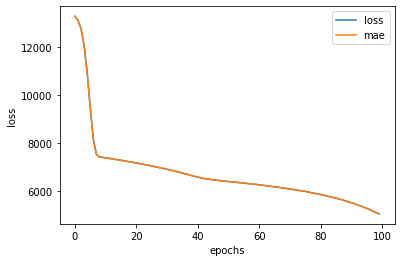

In [ ]:
# Plot history (also known as a loss curve)
pd.DataFrame(history.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

From this, it looks like our model's loss (and MAE) were both still decreasing (in our case, MAE and loss are the same, hence the lines in the plot overlap eachother).

What this tells us is the loss might go down if we try training it for longer. Let's train the same model as above for a little longer. We can do this but calling fit on it again.

In [ ]:
# Try training for a little longer (100 more epochs)
history_2 = insurance_model_2.fit(X_train, y_train, epochs=100, verbose=0)

How did the extra training go?

In [ ]:
# Evaluate the model trained for 200 total epochs
insurance_model_2_loss, insurance_model_2_mae = insurance_model_2.evaluate(X_test, y_test)
insurance_model_2_loss, insurance_model_2_mae

9/9 [==============================] - 0s 2ms/step - loss: 3494.7285 - mae: 3494.7285


(3494.728515625, 3494.728515625)

Training for an extra 100 epochs we see about a 10% decrease in error. Let's see this visually.

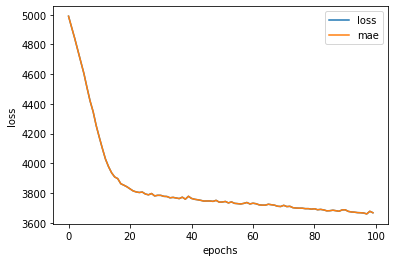

In [ ]:
# Plot the model trained for 200 total epochs loss curves
pd.DataFrame(history_2.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs"); # note: epochs will only show 100 since we overrid the history variable

## Preprocessing data (normalization and standardization)

A common practice when working with neural networks is to make sure all of the data we pass to them is in the range 0 to 1.

This practice is called **normalization** (scaling all values from their original range to, e.g. between 0 and 100,000 to be between 0 and 1).

There is another process call **standardization** which converts all of your data to unit variance and 0 mean.

These two practices are often part of a preprocessing pipeline (a series of functions to prepare our data for use with neural networks).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Read in the insurance dataset
insurance = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")

In [ ]:
# Check out the data
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Now, just as before, we need to transform the non-numerical columns into numbers and this time we'll also be normalizing the numerical columns with different ranges (to make sure they're all between 0 and 1).

To do this, we're going to use a few classes from Scikit-Learn:
* [`make_column_transformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) - build a multi-step data preprocessing function for the folllowing trnasformations:
  * [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - make sure all numerical columns are normalized (between 0 and 1).
  * [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) - one hot encode the non-numerical columns.

Let's see them in action.

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Create column transformer (this will help us normalize/preprocess our data)
ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]), # get all values between 0 and 1
    (OneHotEncoder(handle_unknown="ignore"), ["sex", "smoker", "region"])
)

# Create X & y
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

# Build our train and test sets (use random state to ensure same split as before)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit column transformer on the training data only (doing so on test data would result in data leakage)
ct.fit(X_train)

# Transform training and test data with normalization (MinMaxScalar) and one hot encoding (OneHotEncoder)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

Now we've normalized it and one-hot encoding it, what does our data look like now?

In [ ]:
# Non-normalized and non-one-hot encoded data example
X_train.loc[0]

age                19
sex            female
bmi              27.9
children            0
smoker            yes
region      southwest
Name: 0, dtype: object

In [ ]:
# Normalized and one-hot encoded example
X_train_normal[0]

array([0.60869565, 0.10734463, 0.4       , 1.        , 0.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        ])

Shapes of the datasets:

In [ ]:
# Notice the normalized/one-hot encoded shape is larger because of the extra columns
X_train_normal.shape, X_train.shape

((1070, 11), (1070, 6))

Our data is normalized and numerical, let's model it.

We'll use the same model as `insurance_model_2`.

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Build the model (3 layers, 100, 10, 1 units)
insurance_model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(100),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Dense(1)
])

# Compile the model
insurance_model_3.compile(loss=tf.keras.losses.mae,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae'])

# Fit the model for 200 epochs (same as insurance_model_2)
insurance_model_3.fit(X_train_normal, y_train, epochs=200, verbose=0) 

Let's evaluate the model on normalized test set.

In [ ]:
# Evaulate 3rd model
insurance_model_3_loss, insurance_model_3_mae = insurance_model_3.evaluate(X_test_normal, y_test)

9/9 [==============================] - 0s 2ms/step - loss: 3171.5771 - mae: 3171.5771


And finally, let's compare the results from `insurance_model_2` (trained on non-normalized data) and `insurance_model_3` (trained on normalized data).

In [ ]:
# Compare modelling results from non-normalized data and normalized data
insurance_model_2_mae, insurance_model_3_mae

(3494.728515625, 3171.5771484375)

From this we can see normalizing the data results in 10% less error using the same model than not normalizing the data.